In [16]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
import os
from scipy.interpolate import interp1d


In [17]:
N = 2 ** 23  # Number of sample points (power of 2 for FFT efficiency)
resonator_frequency = 7.252534 * 10 ** 9  # Resonator frequency (Hz)

In [18]:
def s11_for_both_states_mocked(f_resonator: float, target_pulse_frequencies: np.ndarray = None, plot: bool = False):
    # --- S_11 Mock Function for a reflection resonator---
    def get_s11(probe_freq, res_freq_shifted, hwhm_freq, s11_on_res_signed):
        delta_f = probe_freq - res_freq_shifted

        kappa_hwhm_diff_term = s11_on_res_signed * kappa_hwhm

        numerator = 1j * delta_f - kappa_hwhm_diff_term
        denominator = kappa_hwhm + 1j * delta_f
        return numerator / denominator

    # --- Parameters ---
    kappa_hwhm = 1000  # Linewidth (HWHM of |S11| dip)
    chi_2pi = (156 * 10 ** 3) / 2  # Dispersive shift chi/2π
    s11_on_res = 0.1  # |S_11| on resonance

    # Shifted resonant frequencies for qubit states
    f_resonator_0_shifted = f_resonator + chi_2pi
    f_resonator_1_shifted = f_resonator - chi_2pi

    # Sweep omega_RF around omega_r
    omega_rf_sweep = target_pulse_frequencies * 2 * np.pi if target_pulse_frequencies is not None else np.linspace(
        f_resonator * 0.999, f_resonator * 1.001, N)

    s11_0 = get_s11(omega_rf_sweep, f_resonator_0_shifted, kappa_hwhm, s11_on_res)
    s11_1 = get_s11(omega_rf_sweep, f_resonator_1_shifted, kappa_hwhm, s11_on_res)

    s11_phase_0_unwrapped = np.unwrap(np.angle(s11_0))
    s11_phase_1_unwrapped = np.unwrap(np.angle(s11_1))

    # --- Plotting ---
    if plot:
        s11_plot_edges = np.array((-chi_2pi * 3, chi_2pi * 3)) + f_resonator

        fig, ax = plt.subplots(4, 1)

        # Plot 1: Real Part
        ax[0].plot(omega_rf_sweep, np.abs(s11_0), label='|0>')
        ax[0].plot(omega_rf_sweep, np.abs(s11_1), label='|1>')

        ax[0].set_ylabel('$|S_{11}|$')
        ax[0].set_xlim(s11_plot_edges)

        ax[0].grid(True, linestyle=':', alpha=0.7)
        ax[0].legend()

        # Plot 1: Imaginary Part
        ax[1].plot(omega_rf_sweep, np.imag(s11_0))
        ax[1].plot(omega_rf_sweep, np.imag(s11_1))

        ax[1].set_ylabel('$Im[S_{11}]$')
        ax[1].set_xlim(s11_plot_edges)

        ax[1].grid(True, linestyle=':', alpha=0.7)

        # Plot 2: Real Part
        ax[2].plot(omega_rf_sweep, np.real(s11_0))
        ax[2].plot(omega_rf_sweep, np.real(s11_1))

        ax[2].set_ylabel('$Re[S_{11}]$')
        ax[2].set_xlim(s11_plot_edges)

        ax[2].grid(True, linestyle=':', alpha=0.7)

        # Plot 3: Argument
        ax[3].plot(omega_rf_sweep, s11_phase_0_unwrapped)
        ax[3].plot(omega_rf_sweep, s11_phase_1_unwrapped)

        ax[3].set_ylabel('$\\theta$ (rad)')
        ax[3].set_xlabel('Frequency, $\\omega_{RF} - \\omega_r$')
        ax[3].set_xlim(s11_plot_edges)
        ax[3].grid(True, linestyle=':', alpha=0.7)

        plt.tight_layout()

        plt.show()

    return omega_rf_sweep / (2 * np.pi), s11_0, s11_1

In [19]:
def s11_s21_from_s2p_file(simulation_results_filename: str, plot: bool = False):
    current_path = os.path.abspath("")
    data_dir_path = os.path.join(current_path, "data")

    network = rf.Network(os.path.join(data_dir_path, simulation_results_filename))

    s11 = network.s[:, 0, 0]
    s21 = network.s[:, 1, 0]
    # s12 = network.s[:, 0, 1]
    # s22 = network.s[:, 1, 1]
    frequencies = network.f

    if plot:
        fig, ax = plt.subplots(3, 1)

        # Plot 1: Real Part
        ax[0].plot(frequencies, np.abs(s11), label='$S_{11}$')
        ax[0].plot(frequencies, np.abs(s21), label='$S_{21}$')

        ax[0].set_ylabel('$|S_{xx}|$')

        ax[0].grid(True, linestyle=':', alpha=0.7)
        ax[0].legend()

        # Plot 1: Imaginary Part
        ax[1].plot(frequencies, np.imag(s11))
        ax[1].plot(frequencies, np.imag(s21))

        ax[1].set_ylabel('$Im[S_{xx}]$')

        ax[1].grid(True, linestyle=':', alpha=0.7)

        # Plot 2: Real Part
        ax[2].plot(frequencies, np.real(s11))
        ax[2].plot(frequencies, np.real(s21))

        ax[2].set_ylabel('$Re[S_{x}]$')

        ax[2].grid(True, linestyle=':', alpha=0.7)

        plt.show()

    return network.f, s11, s21

In [20]:
def create_rectangle_pulse(f_resonator: float, samples_number: int, target_pulse_frequencies: np.ndarray = None, plot: bool = False, ):
    # --- Time Domain Parameters ---
    total_signal_time = 4 * 10 ** (-4)  # Total time duration of the signal (seconds)
    dt = total_signal_time / N  # Time step (sampling interval)
    t = np.linspace(0, total_signal_time, samples_number, endpoint=False)  # Time vector

    # --- Rectangular Pulse Parameters ---
    pulse_width = 3.5 * 10 ** (-6)  # (seconds)
    pulse_amplitude = 1.0  # a.u.
    pulse_start_time = (total_signal_time - pulse_width) / 2  # (seconds)
    pulse_frequency = f_resonator

    # --- Create the Rectangular Pulse in Time Domain ---
    pulse_signal = np.zeros(N)
    pulse_signal[(t >= pulse_start_time) & (t < pulse_start_time + pulse_width)] = pulse_amplitude
    pulse_signal = pulse_signal * np.exp(1j * pulse_frequency * 2 * np.pi * t)  # Phase = 0

    # --- To Frequency Domain ---
    yf = np.fft.fft(pulse_signal)
    xf = np.fft.fftfreq(N, dt)

    pulse_f_signal = np.fft.fftshift(yf)
    pulse_f_frequencies = np.fft.fftshift(xf)

    result = pulse_f_signal
    if target_pulse_frequencies is not None:
        pulse_spectrum_interpolator = interp1d(
            pulse_f_frequencies,
            pulse_f_signal,
            kind='cubic',
            bounds_error=False,
            fill_value=0
        )

        pulse_f_signal_interpolated = pulse_spectrum_interpolator(target_pulse_frequencies)

        result = pulse_f_signal_interpolated

    result = np.abs(result)
    result_frequencies = pulse_f_frequencies if target_pulse_frequencies is None else target_pulse_frequencies

    # --- Plotting ---
    if plot:
        plt.figure(figsize=(12, 8))

        fig, ax = plt.subplots(2, 1)

        # Plot 1: Time Domain
        ax[0].plot(t, pulse_signal)
        ax[0].set_title('Time Domain')
        ax[0].set_xlabel('Time (s)')
        ax[0].set_ylabel('Amplitude')
        ax[0].set_xlim([pulse_start_time * 0.9, pulse_start_time * 1.1 + pulse_width])
        ax[0].grid(True, linestyle=':', alpha=0.7)

        # Plot 2: Frequency Domain
        pulse_f_plot_edges = (pulse_frequency * 0.9, pulse_frequency * 1.1)

        ax[1].plot(result_frequencies,
                   result)
        ax[1].set_title('Magnitude Spectrum')
        ax[1].set_xlabel('Frequency (Hz)')
        ax[1].set_ylabel('Magnitude')
        ax[1].set_xlim(pulse_f_plot_edges)
        ax[1].grid(True, linestyle=':', alpha=0.7)

        plt.tight_layout()
        plt.show()

    return result_frequencies, result

In [21]:
def readout_signal_after_interaction_with_resonator(s: np.ndarray, pulse: np.ndarray, frequencies: np.ndarray, plot: bool = False):
    result = s * pulse
    if plot:
        plt.plot(frequencies, np.abs(result))
        plt.title('Read out signal after interaction with resonator')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        #plt.xlim((pulse_frequency * 0.9999, pulse_frequency * 1.0001))
        plt.grid(True, linestyle=':', alpha=0.7)

        plt.tight_layout()
        plt.show()
    return result

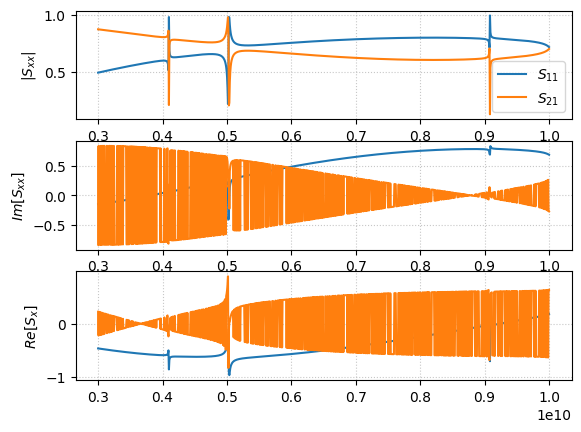

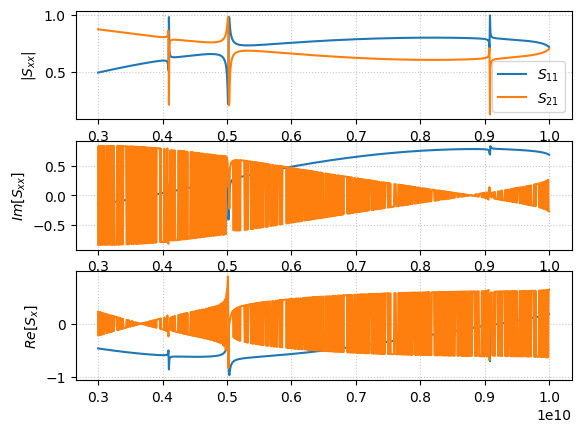

In [26]:
frequencies_simulation_7252456, s11_simulation_7252456, s21_simulation_7252456 = s11_s21_from_s2p_file(
    simulation_results_filename='hfss_resonance_simulator_Resonator_7252456e-6GHz_2_ports_v8.s2p',
    plot=True,
)
frequencies_simulation_7252612, s11_simulation_7252612, s21_simulation_7252612 = s11_s21_from_s2p_file(
    simulation_results_filename='hfss_resonance_simulator_Resonator_7252612e-6GHz_2_ports_v8.s2p',
    plot=True,
)

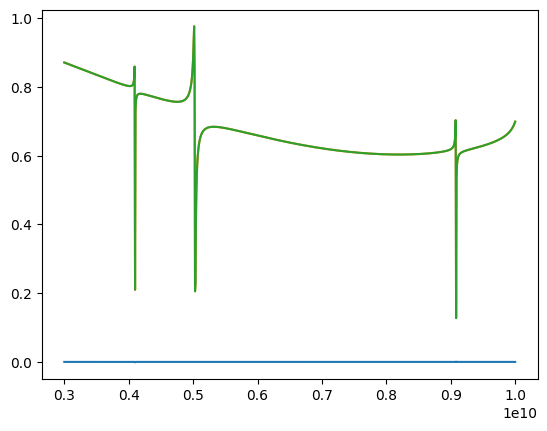

In [32]:
plt.plot(frequencies_simulation_7252456, np.abs(s21_simulation_7252456)-np.abs(s21_simulation_7252612))
plt.plot(frequencies_simulation_7252456, np.abs(s21_simulation_7252456))
plt.plot(frequencies_simulation_7252456, np.abs(s21_simulation_7252612))


<Figure size 1200x800 with 0 Axes>

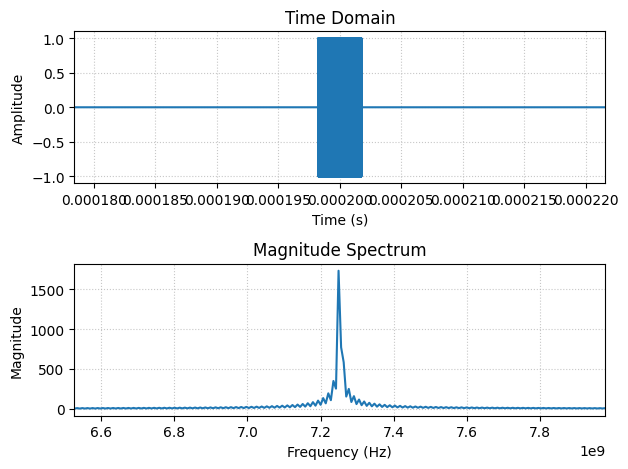

In [23]:
_, pulse_signal = create_rectangle_pulse(target_pulse_frequencies=frequencies_simulation,
                                         f_resonator=resonator_frequency,
                                         samples_number=N,
                                         plot=True)

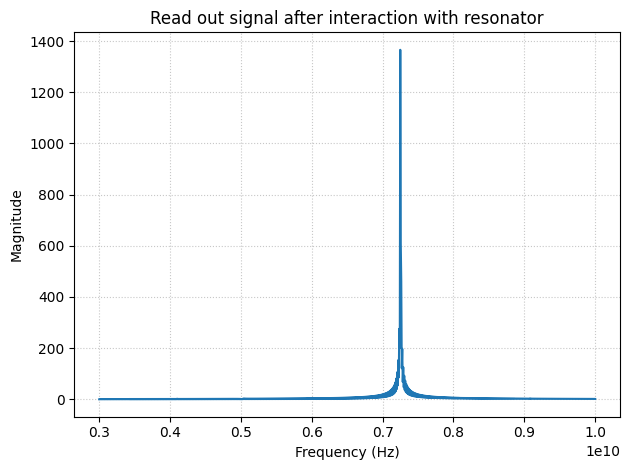

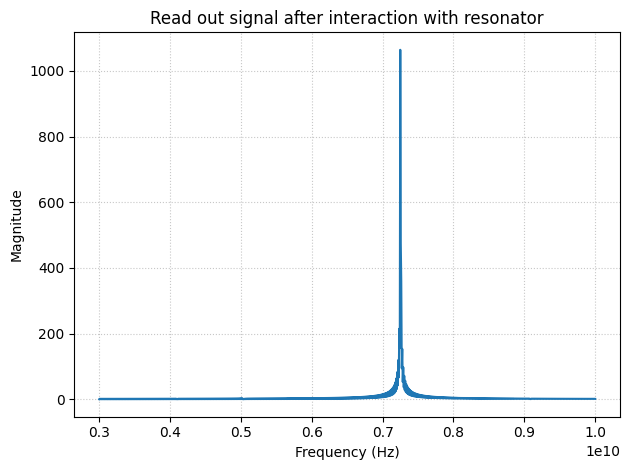

In [24]:
reflected_signal = readout_signal_after_interaction_with_resonator(s=s11_simulation,
                                              pulse=pulse_signal,
                                              frequencies=frequencies_simulation,
                                              plot=True)
transited_signal = readout_signal_after_interaction_with_resonator(s=s21_simulation,
                                              pulse=pulse_signal,
                                              frequencies=frequencies_simulation,
                                              plot=True)

In [25]:
# --- Transform Reflected Signal to Time Domain ---
reflected_pulse_complex_time = np.fft.ifft(reflected_signal)
xf = np.fft.fftfreq(N, dt)

I_reflected = np.real(reflected_pulse_complex_time)
Q_reflected = np.imag(reflected_pulse_complex_time)

plt.scatter(I_reflected, Q_reflected)

NameError: name 'dt' is not defined

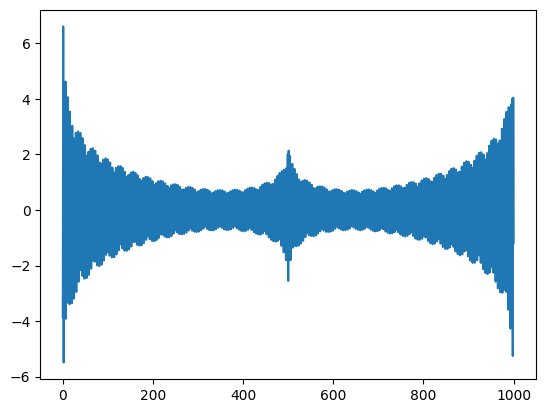

In [15]:
plt.plot(reflected_pulse_complex_time)